# Release Notes

上一个版本：`3.6-xx`等。记不清了，还用了蛮多别的版本的代码。

技巧：直接使用两个季度的数据来训练；特征组合；用median逐列填充。

对模型倒是没什么特别的探究。

# Setting working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/XiamenIntlBank')

Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

In [ ]:
## 安装catboost和lightgbm。
## catboost耗费显存极大，但是飞快；lightgbm好像不是那么的方便，gpu使用不起来。
!pip install catboost
# !pip install featuretools

     |████████████████████████████████| 66.3MB 65kB/s 


# Importing libraries and load datasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, tqdm, re, random, warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, cohen_kappa_score
from collections import Counter, defaultdict
import tensorflow as tf
# import featuretools

# Rudimentary processing

Like encoding some object type data

## Load dataset

In [ ]:
data_train_3 = pd.read_csv('preprocessedData/quarter3_merged-validLabels.csv')
data_train_4 = pd.read_csv('preprocessedData/quarter4_merged-validLabels.csv')
data_train = pd.concat([data_train_3, data_train_4])

# data_train = pd.read_csv('preprocessedData/quarter4_merged-validLabels.csv')

data_test_a = pd.read_csv('preprocessedData/quarter1_merged-validUsers.csv')

## Delete the cols that have too many nulls

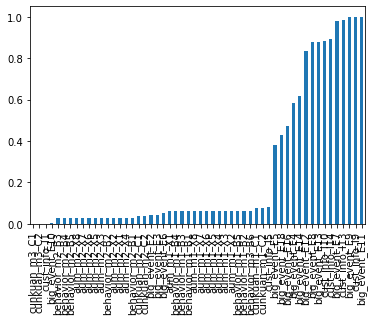

In [ ]:
# nan可视化
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
#     print((missing))
    missing.plot.bar()
seeWhichColumnsHaveMissingValues(data_train)

In [ ]:
def seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, threshold): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > threshold]
    missing.sort_values(inplace=True)
    return list(missing.index)
colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.15)
print(colsThatHaveTooManyNull)

['big_event_E5', 'big_event_E18', 'big_event_E16', 'big_event_E4', 'big_event_E14', 'big_event_E12', 'big_event_E8', 'big_event_E13', 'cust_info_I10', 'cust_info_I14', 'big_event_E7', 'cust_info_I13', 'big_event_E9', 'big_event_E11', 'cust_info_I9']


上述的列，空值太多(多于15%)，有可能会影响结果，故先放弃。

注意，如果你训练集这样搞了，那么你测试集就得删掉一样的列，不论测试集相应的列有多少空值。

In [ ]:
len(data_train.columns)

87

In [ ]:
len(data_test_a.columns)

86

In [ ]:
data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)

## Classify the features into multiple groups

In [ ]:
id_col = ["cust_no"]

In [ ]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
object_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'label'
numerical_fea.remove(label)

In [ ]:
## 过滤类别较少的和较多的列
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
    
numerical_serial_fea,numerical_categorical_fea = get_numerical_serial_fea(data_train,numerical_fea)
print(numerical_serial_fea)
print(numerical_categorical_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11']
['cust_info_I4', 'cust_info_I6', 'cust_info_I7', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20']


`big_event_E11, cust_info_I7, cust_info_I9` from numerical_categorical_fea, 类别太少，没有意义。

In [ ]:
# numerical_categorical_fea.remove("big_event_E11")
numerical_categorical_fea.remove("cust_info_I7")
# numerical_categorical_fea.remove("cust_info_I9")

In [ ]:
data_train.drop(["cust_info_I7"], axis = 1, inplace=True)
data_test_a.drop(["cust_info_I7"], axis = 1, inplace=True)

找日期：所有在`object_fea`里面的`big_event_xx`和`behavior_m3_B6` 是时间类型的。

In [ ]:
date_fea = []
for fea in object_fea:
    if "big_event" in fea or "behavior" in fea:
        date_fea.append(fea)
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E6', 'big_event_E10']


找其他类型的列

In [ ]:
object_categorical_fea = []
for fea in object_fea:
    if fea not in date_fea and fea not in id_col:
        object_categorical_fea.append(fea)
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']


In [ ]:
total_list = sorted(list(data_train.columns))

In [ ]:
id_col

['cust_no']

In [ ]:
print(numerical_serial_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11']


In [ ]:
print(numerical_categorical_fea)

['cust_info_I4', 'cust_info_I6', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20']


In [ ]:
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E6', 'big_event_E10']


In [ ]:
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']


`object_categorical_fea` 还能继续分，有的是有等级的，有的没有等级（这些没有等级的，可以考虑进行那个啥，onehot）

下面的代码用来检查有没有特征被漏掉。

In [ ]:
new_cates = numerical_categorical_fea + numerical_serial_fea + date_fea + object_categorical_fea 

In [ ]:
set(total_list) - set(new_cates)

{'cust_no', 'label'}

如果空留label、ID，则无特征被遗漏。

## Change `object_categorical_fea` 

这里面也有一些类是可以进行序列化的，比如`cust_info_I3`用户的等级, `cust_info_I10`学历, `cust_info_I14`官阶，这几个都可以序列化。

鉴于这个notebook只做最原生态的处理，所以就将之简单归类了。

In [ ]:
object_categorical_fea

['cust_info_I1',
 'cust_info_I3',
 'cust_info_I5',
 'cust_info_I8',
 'cust_info_I12']

对他们进行普通分类，最普通的分类，就是将他们编码为数字。不搞dummy操作。

In [ ]:
def mapTheValue(data, fea, dic):
    """
    data_train is the dataset. 
    fea is the target feature. 
    dic is the mapping dictionary. 
    """
    data[fea] = data[fea].apply(lambda x: dic.get(x, -1)) 


## 这两个特征，是暗含了顺序
for dt in [data_train, data_test_a]: 
    mapTheValue(dt, "cust_info_I3", {
        "普通客户": 0, 
        "黄金": 1,
        "白金": 2,
        "钻石": 3,
    })
    
# for col in tqdm.tqdm(["cust_info_I1", 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']): 
#     le = LabelEncoder()
#     le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
#     data_train[col] = le.transform(list(data_train[col].astype(str).values))
#     data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

## 要用，就用所有的str来编码。这里算是一个修正吧。
cust_info_q3 = pd.read_csv('originalDataset/x_train/cust_info_q3.csv')
cust_info_q4 = pd.read_csv('originalDataset/x_train/cust_info_q4.csv')
cust_info_q1 = pd.read_csv('originalDataset/x_test/cust_info_q1.csv')

for col in tqdm.tqdm(["cust_info_I1", 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']): 
    ## 获取最原处的列名，也就是IXX. 
    originColName = col.split("_")[-1]
    le = LabelEncoder()
    le.fit(list(cust_info_q3[originColName].astype(str).values) + list(cust_info_q4[originColName].astype(str).values) + list(cust_info_q1[originColName].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


In [ ]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv", index=False)

In [ ]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")

## Change `date_fea`


In [ ]:
date_fea

['behavior_m3_B6',
 'big_event_E1',
 'big_event_E2',
 'big_event_E3',
 'big_event_E6',
 'big_event_E10']

注意，date特征和date_DT类型的特征，在入模之前必须要处理成数字才行。

最普通，直接将日期改为距离新千年第一天多少天。

In [ ]:
startdate = datetime.datetime.strptime(
    "2000-01-01 00:00:00",
    '%Y-%m-%d %H:%M:%S'
)
for fea in [ "behavior_m3_B6",  
            'big_event_E1',
             'big_event_E2',
             'big_event_E3',
             'big_event_E6',
             'big_event_E10']:   
    print(fea)
    
    data_train[fea] = data_train[fea].astype(str)
    data_test_a[fea] = data_test_a[fea].astype(str)
    
    ## 这里改为与某一固定日期（千禧年第一天）的距离。否则，不同的表格，这些列所得到的数据的标准不一，这样会出事情的。
    if fea in ["behavior_m3_B6"]: ## 这个列有时分秒，不只有日期。
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format = '%Y-%m-%d %H:%M:%S')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days ## 这里或许有潜力可挖，比如，换成秒，分钟啊什么的。
    else: ## 这些列，只有日期。
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format='%Y-%m-%d')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days

behavior_m3_B6
big_event_E1
big_event_E2
big_event_E3
big_event_E6
big_event_E10


In [ ]:
data_train.shape

(145296, 71)

# Feature Generation

利用 https://zhuanlan.zhihu.com/p/26444240 介绍的方法开展特征合成：

```
median(N1)_by(C1)  \\ 中位数
mean(N1)_by(C1)  \\ 算术平均数
mode(N1)_by(C1)  \\ 众数
min(N1)_by(C1)  \\ 最小值
max(N1)_by(C1)  \\ 最大值
std(N1)_by(C1)  \\ 标准差
var(N1)_by(C1)  \\ 方差
freq(C2)_by(C1)  \\ 频数

freq(C1) \\这个不需要groupby也有意义
```

上述只是一种思路。

## Do something on numerical features. 

对于单个月的统计量

求平均：某月每一个产品平均存款金额

    for i in range(3):
        'cunkuan_m{i}_C1', 某月存款产民金额
        'cunkuan_m{i}_C2', 某月存款产品个数
    
求平均：某月，每一次平均转入多少金额
    
    for i in range(3):
        behavior_m{i}_B2 转账转入次数
        behavior_m{i}_B3 转账转入金额
    
求平均：某月，每一次平均转出多少金额

    for i in range(3):
        'behavior_m{i}_B4', 转账转出次数
        'behavior_m{i}_B5', 转账转出金额

In [ ]:
def calculateAvgWithinMonth_cunkuan_c12(data_train):
#     f'cunkuan_m{i}_C1'#, 某月存款产品金额
#     f'cunkuan_m{i}_C2'#, 某月存款产品个数
    newCols = []
    for i in range(1, 3+1):
        data_train[f"cunkuan_m{i}_C1-C2"] = data_train[f'cunkuan_m{i}_C1'] / data_train[f'cunkuan_m{i}_C2']
        newCols.append(f"cunkuan_m{i}_C1-C2")
    return newCols

newCols_data_train = calculateAvgWithinMonth_cunkuan_c12(data_train)
newCols_data_test_a = calculateAvgWithinMonth_cunkuan_c12(data_test_a)
data_train.shape

(145296, 74)

In [ ]:
def calculateAvgWithinMonth_behavior_b32(data_train):
#     behavior_m{i}_B2 # 转账转入次数
#     behavior_m{i}_B3 # 转账转入金额
    newCols = []
    for i in range(1, 3+1):
        data_train[f"behavior_m{i}_B3-B2"] = data_train[f'behavior_m{i}_B3'] / data_train[f'behavior_m{i}_B2']
        newCols.append(f"behavior_m{i}_B3-B2")
    return newCols

newCols_data_train = calculateAvgWithinMonth_behavior_b32(data_train)
newCols_data_test_a = calculateAvgWithinMonth_behavior_b32(data_test_a)
data_train.shape

(145296, 77)

In [ ]:
def calculateAvgWithinMonth_behavior_b54(data_train):
#     behavior_m{i}_B2 # 转账转入次数
#     behavior_m{i}_B3 # 转账转入金额
    newCols = []
    for i in range(1, 3+1):
        data_train[f"behavior_m{i}_B5-B4"] = data_train[f'behavior_m{i}_B5'] / data_train[f'behavior_m{i}_B4']
        newCols.append(f"behavior_m{i}_B5-B4")
    return newCols

newCols_data_train = calculateAvgWithinMonth_behavior_b54(data_train)
newCols_data_test_a = calculateAvgWithinMonth_behavior_b54(data_test_a)
data_train.shape

(145296, 80)

对于单个的统计量，我们可以计算每一个月的增长率
    
    for i in range(1, 8+1):
        aum_m2_X{i} 相对于 aum_m1_X{i} 增长了多少，
        aum_m3_X{i} 相对于 aum_m2_X{i} 增长了多少，
        aum_m3_X{i} 相对于 aum_m1_X{i} 增长了多少，
        
    for i in range(1, 5 + 1): 
        behavior_m2_B{i} 相对于 behavior_m1_B{i} 增长了多少，
        behavior_m3_B{i} 相对于 behavior_m2_B{i} 增长了多少，
        behavior_m3_B{i} 相对于 behavior_m1_B{i} 增长了多少，
        
    for i in range(1, 2 + 1):
        cunkuan_m2_C{i} 相对于 cunkuan_m1_C{i} 增长了多少，
        cunkuan_m3_C{i} 相对于 cunkuan_m2_C{i} 增长了多少，
        cunkuan_m3_C{i} 相对于 cunkuan_m1_C{i} 增长了多少，

In [ ]:
def incrementalRate_aum_m32_m21(data_train):
#     aum_m2_X{i} 相对于 aum_m1_X{i} 增长了多少，
#     aum_m3_X{i} 相对于 aum_m2_X{i} 增长了多少，
    newCols = []
    for i in range(1, 8+1):
        data_train[f"aum_m21_X{i}"] = (data_train[f"aum_m2_X{i}"] - data_train[f"aum_m1_X{i}"]) / data_train[f"aum_m1_X{i}"]
        data_train[f"aum_m32_X{i}"] = (data_train[f"aum_m3_X{i}"] - data_train[f"aum_m2_X{i}"]) / data_train[f"aum_m2_X{i}"]
        newCols.extend([f"aum_m21_X{i}", f"aum_m32_X{i}"])
    return newCols

newCols_data_train = incrementalRate_aum_m32_m21(data_train)
newCols_data_test_a = incrementalRate_aum_m32_m21(data_test_a)
data_train.shape

(145296, 96)

In [ ]:
def incrementalRate_behavior_m32_m21(data_train):
#     behavior_m2_B{i} 相对于 behavior_m1_B{i} 增长了多少，
#     behavior_m3_B{i} 相对于 behavior_m2_B{i} 增长了多少，
    newCols = []
    for i in range(1, 5 + 1):
        data_train[f"behavior_m21_B{i}"] = (data_train[f"behavior_m2_B{i}"] - data_train[f"behavior_m1_B{i}"]) / data_train[f"behavior_m1_B{i}"]
        data_train[f"behavior_m32_B{i}"] = (data_train[f"behavior_m3_B{i}"] - data_train[f"behavior_m2_B{i}"]) / data_train[f"behavior_m2_B{i}"]
        newCols.extend([f"behavior_m21_B{i}", f"behavior_m32_B{i}"])
    return newCols

newCols_data_train = incrementalRate_behavior_m32_m21(data_train)
newCols_data_test_a = incrementalRate_behavior_m32_m21(data_test_a)
data_train.shape

(145296, 106)

In [ ]:
def incrementalRate_cunkuan_m32_m21(data_train):
#     cunkuan_m2_C{i} 相对于 cunkuan_m1_C{i} 增长了多少，
#     cunkuan_m3_C{i} 相对于 cunkuan_m2_C{i} 增长了多少，
    newCols = []
    for i in range(1, 2 + 1):
        data_train[f"cunkuan_m21_C{i}"] = (data_train[f"cunkuan_m2_C{i}"] - data_train[f"cunkuan_m1_C{i}"]) / data_train[f"cunkuan_m1_C{i}"]
        data_train[f"cunkuan_m32_C{i}"] = (data_train[f"cunkuan_m3_C{i}"] - data_train[f"cunkuan_m2_C{i}"]) / data_train[f"cunkuan_m2_C{i}"]
        newCols.extend([f"cunkuan_m21_C{i}", f"cunkuan_m32_C{i}"])
    return newCols

newCols_data_train = incrementalRate_cunkuan_m32_m21(data_train)
newCols_data_test_a = incrementalRate_cunkuan_m32_m21(data_test_a)
data_train.shape

(145296, 110)

In [ ]:
data_train.shape

(145296, 110)

In [ ]:
# data_train[newCols_data_train].head()

生成了很多空值。就处理一下吧。

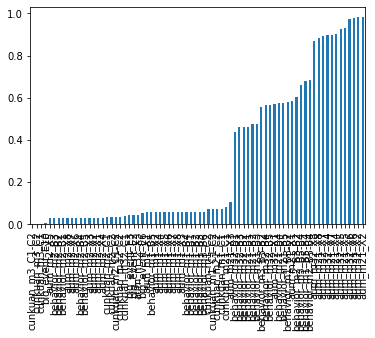

In [ ]:
seeWhichColumnsHaveMissingValues(data_train)

In [ ]:
colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.15)
print(colsThatHaveTooManyNull)

['behavior_m32_B1', 'behavior_m32_B3', 'behavior_m32_B2', 'behavior_m21_B1', 'behavior_m21_B3', 'behavior_m21_B2', 'behavior_m3_B3-B2', 'behavior_m32_B5', 'behavior_m32_B4', 'aum_m32_X1', 'behavior_m21_B4', 'behavior_m21_B5', 'behavior_m1_B3-B2', 'aum_m21_X1', 'behavior_m2_B3-B2', 'behavior_m3_B5-B4', 'behavior_m1_B5-B4', 'behavior_m2_B5-B4', 'aum_m32_X8', 'aum_m21_X8', 'aum_m32_X7', 'aum_m32_X4', 'aum_m21_X7', 'aum_m21_X4', 'aum_m32_X5', 'aum_m21_X5', 'aum_m32_X6', 'aum_m21_X6', 'aum_m32_X2', 'aum_m21_X2']


In [ ]:
data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)

In [ ]:
data_train.shape

(145296, 80)

In [ ]:
####
## 这个适用于F2及以后。
##
####
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

def selectNFeatures(numSelectedFeatures, data_train, y_train, fillMethod = "ffill"):
    ## 到时候，就指着返回下面两个表了
    selectedFeatures = []
    # deletedFeatures = []

    ## 无脑处理：将所有的正负无穷都处理掉。
    data_train = data_train.replace([np.inf, -np.inf], np.nan)
    ## 填充方法
    if fillMethod in ["ffill", "bfill"]:
        data_train = data_train.fillna(axis = 1, method = fillMethod) # "ffill"
    else: 
        for col in data_train.columns:
            data_train[col] = data_train[col].fillna(data_train[col].median())  

    ## columnsThatHaveNullVal 这些列，终究是有空值的，那就放弃他们吧。
    tmpList = data_train.isnull().sum().to_frame('nulls')
    columnsThatHaveNullVal = list(tmpList[tmpList["nulls"] > 0].index)
    # deletedFeatures.extend(columnsThatHaveNullVal)
    data_train.drop(columnsThatHaveNullVal, axis = 1, inplace=True)

    # print(data_train.isnull().sum())
    # print()
    # print(y_train.isnull().sum())
    # print(data_train.head(20))
    # print(np.any(np.isnan(data_train)))

    selector = SelectKBest(k=numSelectedFeatures)
    selector.fit(data_train, y_train)
    colNums = selector.get_support(True)
    # print(colNums)
    for i, col in enumerate(list(data_train.columns)):
        if i in colNums:
            selectedFeatures.append(col)
        # else: 
        #     deletedFeatures.append(col)
    # print(selectedFeatures, deletedFeatures)
            
    return selectedFeatures #, deletedFeatures

def combinationOfFeatures(category, serial, method, method_name, data_train, data_test_a, n):
    '''
    combine and generate some new features. 

    category: list of the categorical column names
    serial: list of the serial column names
    method: ["mean"], ["max"], ["min"], pd.Series.model, etc..
    method_name: the name of the method. Must be strings. 
    n: newly generated features, select n from them. if n == -1, then select all of the newly generated features. 
    '''
    ori_cols_train = list(data_train.columns)
    ori_cols_test = list(data_test_a.columns)

    new_cols = []
    
    for col in tqdm.tqdm_notebook(category): 
        for numFea in tqdm.tqdm_notebook(serial): #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
            # print("categorical: {}, serial: {}".format(col, numFea))
            temp_dict = data_train.groupby([col])[numFea].agg(method).reset_index().rename(columns={method_name: col + '_{}_{}'.format(numFea, method_name)})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_{}_{}'.format(numFea, method_name)].to_dict()
            
            data_train[col + '_{}_{}'.format(numFea, method_name)] = data_train[col].map(temp_dict)
            data_test_a[col + '_{}_{}'.format(numFea, method_name)] = data_test_a[col].map(temp_dict)
            
            new_cols.append(col + '_{}_{}'.format(numFea, method_name))
    
    if n >= 0: 
        tmp_train = data_train[new_cols].copy()

        selectedFeatures = selectNFeatures(n, tmp_train, data_train[["label"]]) #, deletedFeatures

        # data_train.drop(deletedFeatures, axis = 1, inplace=True)
        # data_test_a.drop(deletedFeatures, axis = 1, inplace=True)
        data_train = data_train[ori_cols_train + selectedFeatures]
        data_test_a = data_test_a[ori_cols_test + selectedFeatures]

    elif n < 0:
        pass

    return data_train, data_test_a

def combinationOfFeatures_divide(feaGroup1, feaGroup2, method, df, df_test, n):
    ori_cols_train = list(df.columns)
    ori_cols_test = list(df_test.columns)

    new_cols = []

    for fea1 in tqdm.tqdm_notebook(feaGroup1): ## grade
        for fea2 in tqdm.tqdm_notebook(feaGroup2): ## nXX
            
            df['{}_to_{}_'.format(fea1, method) + fea2] = df[fea1] / df.groupby([fea2])[fea1].transform(method)
            df_test['{}_to_{}_'.format(fea1, method) + fea2] = df_test[fea1] / df_test.groupby([fea2])[fea1].transform(method)
            
            new_cols.append('{}_to_{}_'.format(fea1, method) + fea2)
    # print(new_cols)
    
    if n >= 0:
        tmp_train = df[new_cols].copy()
        
        selectedFeatures = selectNFeatures(n, tmp_train, df[["label"]], "median") # , deletedFeatures
        # print(data_train.columns)
        # print(data_train.)
        # print(selectedFeatures)
        
        # df.drop(deletedFeatures, axis = 1, inplace=True)
        # df_test.drop(deletedFeatures, axis = 1, inplace=True)
        df = df[ori_cols_train + selectedFeatures]
        df_test = df_test[ori_cols_test + selectedFeatures]
    
    elif n < 0:
        pass

    return df, df_test

In [ ]:
data_train, data_test_a = combinationOfFeatures(
    object_categorical_fea + numerical_categorical_fea, #numerical_category_manyValues + ['earliesCreditLineYear', 'earliesCreditLineMonth', 'issueYear', 'issueMonth'] + numerical_category_fewValues, 
    numerical_serial_fea, #object_serial + numerical_serial + ["isDefault"],
    ["mean"], 
    "mean", 
    data_train, 
    data_test_a, 
    5
)

In [ ]:
data_train, data_test_a = combinationOfFeatures_divide(
    numerical_categorical_fea, #["grade", "subGrade"], 
    numerical_serial_fea, # ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10',"n11", "n12", 'n13','n14'], 
    "mean", 
    data_train,
    data_test_a, 
    5,
)

In [ ]:
data_train.shape

(145296, 90)

# ~~Combine the `featuretools` data~~

这一部分重要。

In [ ]:
def getNewlyGeneratedFeaturetoolsFeature(directory):
    counter = 0
    newFeatures = pd.DataFrame()
    custNoCol = pd.DataFrame()
    for etyId in ["aum_m", "behavior_m", "cunkuan_m", "big_event", ]:
        for agg in ["sum", "max", "mode", "min", "count", "num_unique", "mean", "percent_true", "std", "skew", ]: 
            counter += 1
            print(f"{etyId}-{agg}.csv", counter)
            features = pd.read_csv(f"preprocessedData/{directory}/{etyId}-{agg}.csv")
            custNoCol = features[["cust_no"]]
            ## 把原始的Ixx列都删掉，然后和原列整合
            features.drop(
                [col for col in features.columns if re.search("^I\d+$", col) != None] + ["cust_no"], 
                axis = 1, 
                inplace=True
            )
            newFeatures = pd.concat([newFeatures, features], axis=1)
    newFeatures = pd.concat([custNoCol, newFeatures], axis=1)
    return newFeatures

newFeatures_q4 = getNewlyGeneratedFeaturetoolsFeature("featuretools-agg-q3-scheme1")
newFeatures_q1 = getNewlyGeneratedFeaturetoolsFeature("featuretools-agg-q1-scheme1")

aum_m-sum.csv 1
aum_m-max.csv 2
aum_m-mode.csv 3
aum_m-min.csv 4
aum_m-count.csv 5
aum_m-num_unique.csv 6
aum_m-mean.csv 7
aum_m-percent_true.csv 8
aum_m-std.csv 9
aum_m-skew.csv 10
behavior_m-sum.csv 11
behavior_m-max.csv 12
behavior_m-mode.csv 13
behavior_m-min.csv 14
behavior_m-count.csv 15
behavior_m-num_unique.csv 16
behavior_m-mean.csv 17
behavior_m-percent_true.csv 18
behavior_m-std.csv 19
behavior_m-skew.csv 20
cunkuan_m-sum.csv 21
cunkuan_m-max.csv 22
cunkuan_m-mode.csv 23
cunkuan_m-min.csv 24
cunkuan_m-count.csv 25
cunkuan_m-num_unique.csv 26
cunkuan_m-mean.csv 27
cunkuan_m-percent_true.csv 28
cunkuan_m-std.csv 29
cunkuan_m-skew.csv 30
big_event-sum.csv 31
big_event-max.csv 32
big_event-mode.csv 33
big_event-min.csv 34
big_event-count.csv 35
big_event-num_unique.csv 36
big_event-mean.csv 37
big_event-percent_true.csv 38
big_event-std.csv 39
big_event-skew.csv 40
aum_m-sum.csv 1
aum_m-max.csv 2
aum_m-mode.csv 3
aum_m-min.csv 4
aum_m-count.csv 5
aum_m-num_unique.csv 6
aum_m-mea

In [ ]:
data_train = pd.merge(data_train, newFeatures_q4, how='inner', on=['cust_no'])
data_test_a = pd.merge(data_test_a, newFeatures_q1, how='inner', on=['cust_no'])

In [ ]:
data_train.shape

(69126, 476)

删掉null太多的列。

In [ ]:
while True:
#     seeWhichColumnsHaveMissingValues(data_train)
    colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.15)
    if len(colsThatHaveTooManyNull):
        print(colsThatHaveTooManyNull)
        data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
        data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)
    else:
        break

['MEAN(big_event.big_event_E5)', 'MIN(big_event.big_event_E5)', 'MAX(big_event.big_event_E5)', 'MEAN(big_event.big_event_E18)', 'MIN(big_event.big_event_E18)', 'MAX(big_event.big_event_E18)', 'MIN(big_event.big_event_E16)', 'MEAN(big_event.big_event_E16)', 'MAX(big_event.big_event_E16)', 'MEAN(big_event.big_event_E4)', 'MIN(big_event.big_event_E4)', 'MAX(big_event.big_event_E4)', 'MIN(big_event.big_event_E14)', 'MAX(big_event.big_event_E14)', 'MEAN(big_event.big_event_E14)', 'MAX(big_event.big_event_E12)', 'MEAN(big_event.big_event_E12)', 'MIN(big_event.big_event_E12)', 'MEAN(big_event.big_event_E13)', 'MIN(big_event.big_event_E13)', 'MAX(big_event.big_event_E13)', 'MEAN(big_event.big_event_E8)', 'MAX(big_event.big_event_E8)', 'MIN(big_event.big_event_E8)', 'MEAN(big_event.big_event_E7)', 'MAX(big_event.big_event_E7)', 'MIN(big_event.big_event_E7)', 'MEAN(big_event.big_event_E9)', 'MIN(big_event.big_event_E9)', 'MAX(big_event.big_event_E9)', 'SKEW(cunkuan_m.cunkuan_m1_C1)', 'SKEW(cunku

In [ ]:
# data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
# data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)
# data_train.shape

In [ ]:
data_train.head()

,cust_no,aum_m1_X1,aum_m1_X2,aum_m1_X3,aum_m1_X4,aum_m1_X5,aum_m1_X6,aum_m1_X7,aum_m1_X8,aum_m2_X1,...,MIN(big_event.big_event_E3),MIN(big_event.big_event_E6),COUNT(big_event),MEAN(big_event.big_event_E1),MEAN(big_event.big_event_E10),MEAN(big_event.big_event_E15),MEAN(big_event.big_event_E17),MEAN(big_event.big_event_E2),MEAN(big_event.big_event_E3),MEAN(big_event.big_event_E6)
0,0xb2d30bf6,0.0,0.0,15774.75,0.0,0.0,0.0,0.0,0.0,0.0,...,6423.0,7044.0,1,6422.0,7211.0,0.0,0.0,6423.0,6423.0,7044.0
1,0xb2d0c143,110000.0,0.0,20000.30,0.0,0.0,0.0,0.0,0.0,130000.0,...,5674.0,6859.0,1,5674.0,6949.0,0.0,0.0,5674.0,5674.0,6859.0
2,0xb2d6004d,70000.0,0.0,13.93,0.0,0.0,0.0,0.0,0.0,70000.0,...,6907.0,6907.0,1,6907.0,7037.0,0.0,0.0,6907.0,6907.0,6907.0
3,0xb2d5a839,153000.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,153000.0,...,6856.0,6880.0,1,6856.0,6928.0,30000.0,20000.0,6856.0,6856.0,6880.0
4,0xb2d63b24,167000.0,0.0,8.99,0.0,0.0,0.0,0.0,0.0,167000.0,...,6968.0,7209.0,1,6948.0,7208.0,0.0,0.0,6968.0,6968.0,7209.0


# ~~Last data processing~~

~~可以再填充一轮na，~~

In [ ]:
# x_train.fillna(method='ffill', inplace=True)
# x_test.fillna(method='ffill', inplace=True)

然后做一下什么归一化. 

In [ ]:
featuresExceptForIDAndLabel = [col for col in data_train.columns if col not in ["cust_no", "label"]]

In [ ]:
data_train[featuresExceptForIDAndLabel] = data_train[featuresExceptForIDAndLabel].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
data_test_a[featuresExceptForIDAndLabel] = data_test_a[featuresExceptForIDAndLabel].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

未来，可以做：
* 分箱
* 异常值处理
* 特征选择，选取最重要的几个特征

In [ ]:
data_train.shape

(69126, 315)

In [ ]:
data_train.columns

Index(['cust_no', 'aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4',
       'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1',
       ...
       'MIN(big_event.big_event_E3)', 'MIN(big_event.big_event_E6)',
       'COUNT(big_event)', 'MEAN(big_event.big_event_E1)',
       'MEAN(big_event.big_event_E10)', 'MEAN(big_event.big_event_E15)',
       'MEAN(big_event.big_event_E17)', 'MEAN(big_event.big_event_E2)',
       'MEAN(big_event.big_event_E3)', 'MEAN(big_event.big_event_E6)'],
      dtype='object', length=315)

# Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

In [ ]:
features = [f for f in data_train.columns if f not in ["cust_no", "label"] and '_outliers' not in f]
y_train = data_train['label'].map({-1: 0, 0: 1, 1: 2})
x_train = data_train[features]
x_test = data_test_a[features]

# Save preprocessed data if necessary

In [ ]:
# x_train.to_csv("preprocessedData/x_train-3.5-q3.csv", index=False)
# x_test.to_csv("preprocessedData/x_test-3.5-q3.csv", index=False)
# y_train.to_csv("preprocessedData/y_train-3.5-q3.csv", index=False)

# Load preprocessed data if applicable

In [ ]:
# x_train_3 = pd.read_csv("preprocessedData/x_train-3.5-q3.csv")
# x_test_3 = pd.read_csv("preprocessedData/x_test-3.5-q3.csv")
# y_train_3 = pd.read_csv("preprocessedData/y_train-3.5-q3.csv", header=None)

# x_train_4 = pd.read_csv("preprocessedData/x_train-3.5.csv")
# x_test_4 = pd.read_csv("preprocessedData/x_test-3.5.csv")
# y_train_4 = pd.read_csv("preprocessedData/y_train-3.5.csv", header=None)

# x_train = pd.concat([x_train_3, x_train_4])
# x_test = pd.concat([x_test_3, x_test_4])
# y_train = pd.concat([y_train_3, y_train_4])

In [ ]:
# x_train = pd.read_csv("preprocessedData/x_train-3.7.csv")
# x_test = pd.read_csv("preprocessedData/x_test-3.7.csv")
# y_train = pd.read_csv("preprocessedData/y_train-3.7.csv", header=None)

In [ ]:
x_train.shape

(145296, 88)

In [ ]:
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
#     print((missing))
    missing.plot.bar()

def seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, threshold): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > threshold]
    missing.sort_values(inplace=True)
    return list(missing.index)

## 不知道为什么，x_train还有null很多的列。为什么之前那一轮筛查的时候没发现？
while True:
    colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(x_train, 0.99)
    if len(colsThatHaveTooManyNull):
        print(colsThatHaveTooManyNull)
        x_train = x_train.drop(colsThatHaveTooManyNull, axis=1)
        x_test = x_test.drop(colsThatHaveTooManyNull, axis=1)
    else:
        break

In [ ]:
# x_train = x_train.head(1000)
# x_test = x_test.head(1000)
# y_train = y_train.head(1000)

In [ ]:
def fillDF(data_train):
    for col in data_train.columns:
        data_train[col] = data_train[col].fillna(data_train[col])

fillDF(data_train) #x_train.fillna(x_train.median())
fillDF(data_train) #x_test.fillna(x_test.median())
data_train.shape

(145296, 90)

做一下特征选区。删掉一些特征。前提是填充掉空值。

In [ ]:
# from sklearn.feature_selection import SelectPercentile, chi2
# x_new = SelectPercentile(chi2, percentile=90).fit(x_train_fill, y_train)
# newParams = x_new.get_support(True)

In [ ]:
# selectedFeatureNames = []
# for i, col in enumerate(list(x_train_fill.columns)):
#     if i in newParams:
#         selectedFeatureNames.append(col)
# len(selectedFeatureNames)

In [ ]:
# x_train_selected = x_train[selectedFeatureNames]
# x_test_selected = x_test[selectedFeatureNames]

# Some hands on model training

In [ ]:
testA_result = pd.read_csv('originalDataset/submission_sample.csv')
testA_result_pred = testA_result.copy()

### Scheme A

普通方案. 单个模型. 

似乎啊，不用stratifiedkfold，有的时候效果更好欸。但是如果用的话，会不会更稳呢？
    
    我感觉不会。因为用了StratifiedKFold, 那么拟合出来的模型就适应于原有的label分布，而真实的label分布是怎样的谁知道呢。没有道理认为测试集的数据label分布会和训练集一样。那么，在训练的时候保持训练集的label分布，意义何在？

In [ ]:
x_train.shape

(145296, 88)

In [ ]:
def getTheFinalVotingResult(l):
    dic = defaultdict(list)
    maxNum = -1
    for i, j in Counter(l).items():
        ## i是l里面的数字，j是i在l出现的次数
        maxNum = max(maxNum, j)
        ## 根据出现次数，来归类i
        dic[j].append(i)
    return random.choice(dic[maxNum])

def kappa_withSklearn_lgb(y_pred, y):
    # print(y_pred.shape)
    index_array = np.argmax(np.reshape(y_pred, (-1, 3)), axis=-1)
    return "Kappa~~", cohen_kappa_score(index_array, y.get_label().astype(int)), True

def kappa_withSklearn_xgb(y_pred, y):
    index_array = np.argmax(y_pred, axis=-1)
    return "Kappa", cohen_kappa_score(index_array, y.get_label().astype(int)) * -1

def kappaMyImplementation(sample_y, sample_pred): 
    ## 我自己实现的kappa 
    ## https://baike.baidu.com/item/kappa%E7%B3%BB%E6%95%B0/9385025
    p0 = accuracy_score(sample_y, sample_pred)
    y_count = Counter(sample_y)
    pred_count = Counter(sample_pred)
    n = len(sample_y)
    s = 0
    for l in [-1, 0, 1]:
        ai = y_count.get(l, 0)
        bi = pred_count.get(l, 0)
        s += ai * bi
    pe = s / (n * n)
    return "Kappa", (p0 - pe) / (1 - pe), True

def cv_model(clf, train_x, train_y, test_x, clf_name, folds = 5):
    # folds = 5
    seed = 2020
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    newStackingTestSet = pd.DataFrame(columns=["k{}".format(i + 1) for i in range(folds)])

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_class': 3,
#                 'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,    
#                 'device_type': 'gpu',
#                 'max_bin': 63
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], 
                              verbose_eval=200, early_stopping_rounds=200, 
                              feval= kappa_withSklearn_lgb,  
                             )
            val_pred_ = model.predict(val_x, num_iteration=model.best_iteration)
            print(val_pred_.shape)
            test_pred_ = model.predict(test_x, num_iteration=model.best_iteration)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            # params = {
            #         'booster': 'gbtree',
            #         'nthread': 36,

            #         'eta': 0.1, 
            #         'gamma': 5,
            #         'max_depth': 10,
            #         'min_child_weight': 10,
            #         'subsample': 0.7, 
            #         "colsample_by": {'colsample_bytree':0.5, 'colsample_bylevel':0.5, 'colsample_bynode':0.5}, ## 曾经是0.7, 0.7
            #         'lambda': 50,
            #         'alpha': 10,
            #         'tree_method': "gpu_hist", #  # 
                    
            #         'objective': 'multi:softprob',
            #         "num_class": 3, 
            #         'seed': 2020,

            #         "silent": True,
            #         ###
            #     }
            params = {'booster': 'gbtree',
                      'objective': 'multi:softprob',
                      "num_class": 3, 
#                       'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04, 
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,

                      'tree_method': "gpu_hist", #  # 
#                       'tree_method': 'exact',
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, 
                              evals=watchlist, verbose_eval=200, early_stopping_rounds=200, 
                             feval = kappa_withSklearn_xgb
                             )
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred_  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred_ = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
                 
        if clf_name == "cat":
            ## https://catboost.ai/docs/concepts/python-reference_parameters-list.html
            params = {
                'learning_rate': 0.1, 
                'depth': 12, ## 曾经测试过15，但是一旦设置到15，就会奇慢无比
                'l2_leaf_reg': 80, #100 #50 # 设为20，能够达到40xx的分数。 
                'bootstrap_type': "Bernoulli", ## "Bayesian"比Bernoulli 略强点. 然后我们试试Bernoulli和subsample参数的组合吧。
                # "bagging_temperature": 2, ## 这个参数要跟bayesian bootstrap方法组合起来用。
                "subsample": 0.7, ## 窝槽，bernoulli+subsample加起来很吊啊。。。
                # "sampling_frequency": "PerTree", ## 这个设了没设一样。

                "grow_policy": "Depthwise", ## 这个有奇效。应该还有潜力可挖。
                "min_data_in_leaf": 2, ## 这个也有效果。默认是1，我估计这样搞就太精确了，容易导致过拟合。所以把区间放大一点效果反倒好。
                ## 上面两个，能够达到4236的分数。

                ## 如果要用这个参数，不要弄onehot。都交给catboost吧。
                "one_hot_max_size": 255, ## 能提高一点点。0.0002吧。

                ## 设置的大了，性能可能会下降。原档案警告如上。
                "fold_permutation_block": 2, ## 可能有效。可以关注一下。 设为2，达到了4250

                ## Balanced跑了两次，最高得到了4286的结果。不太稳定。
                "auto_class_weights": "SqrtBalanced",## 得到了4484，升级明显，多测几次，看看是不是偶然 

                ## 这个参数酌情不设吧。因为这个的作用应该跟StratifiedKFold一样吧。
                "allow_const_label": True,

                'od_type': 'Iter', 
                'od_wait': 300, 

                ## MinEntropy和默认值比较好，其他的比较拉垮。
                "feature_border_type": "MinEntropy", 

                'random_seed': 11, 
                'allow_writing_files': False, 
                "task_type": "GPU",
                "eval_metric": "Kappa", 
            }
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x).ravel()
            test_pred = model.predict(test_x).ravel()
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        # test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(cohen_kappa_score(val_y, val_pred))
        print(sum(cv_scores)/len(cv_scores), cv_scores)

        newStackingTestSet["k{}".format(i + 1)] = test_pred

    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)

    newStackingTestSet["voteRst"] = newStackingTestSet[list(newStackingTestSet.columns)].apply(getTheFinalVotingResult, axis = 1)
    # print(newStackingTestSet)
    # print(cohen_kappa_score(y_train, train))

    return train, newStackingTestSet, np.mean(cv_scores) # test / kf.n_splits

In [ ]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test, lgb_meanPerf = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test, lgb_meanPerf

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test, xgb_meanPerf = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test, xgb_meanPerf

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test, cat_meanPerf = cv_model(CatBoostClassifier, x_train, y_train, x_test, "cat")
    return cat_train, cat_test, cat_meanPerf

In [ ]:
xgb_train, xgb_test, xgb_meanPerf= xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[0]	train-merror:0.292792	eval-merror:0.295114	train-Kappa:-0.360246	eval-Kappa:-0.356493
Multiple eval metrics have been passed: 'eval-Kappa' will be used for early stopping.

Will train until eval-Kappa hasn't improved in 200 rounds.
[200]	train-merror:0.266776	eval-merror:0.274019	train-Kappa:-0.422716	eval-Kappa:-0.408223
[400]	train-merror:0.25431	eval-merror:0.269959	train-Kappa:-0.457663	eval-Kappa:-0.424671
[600]	train-merror:0.245389	eval-merror:0.267515	train-Kappa:-0.480247	eval-Kappa:-0.433297
[800]	train-merror:0.238033	eval-merror:0.266414	train-Kappa:-0.497992	eval-Kappa:-0.4375
[1000]	train-merror:0.23091	eval-merror:0.265313	train-Kappa:-0.514429	eval-Kappa:-0.441143
[1200]	train-merror:0.224027	eval-merror:0.265864	train-Kappa:-0.53029	eval-Kappa:-0.44059
Stopping. Best iteration:
[1098]	train-merror:0.227159	eval-merror:0.265107	train-Kappa:-0.52324	eval-Kappa:-0.442285

0.44228547449747324 [

In [ ]:
testA_result_pred["label"] = xgb_test.iloc[:,-1]
### 注释掉的两行，酌情运行。
# testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# testA_result_pred.fillna(0.0, inplace=True)
testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [ ]:
# ### 注意###############
## 最后存成文件的时候，要把类别的标签改回-1，0，1.
testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
testA_result_pred.to_csv("submissionResults/3.7-2Q-xgb-{:.4}.csv".format(xgb_meanPerf), index=False) ## 

-------

In [ ]:
## 最后提交的结果，并不好。
cat_train, cat_test, cat_meanPerf = cat_model(x_train, y_train, x_test)
# cat_train, cat_test, cat_meanPerf = cat_model(x_train_selected, y_train, x_test_selected)

************************************ 1 ************************************
0:	learn: 0.4784748	test: 0.3927313	best: 0.3927313 (0)	total: 87.1ms	remaining: 29m 1s
500:	learn: 0.6809074	test: 0.4653853	best: 0.4677042 (469)	total: 25.4s	remaining: 16m 28s
bestTest = 0.4677042183
bestIteration = 469
Shrink model to first 470 iterations.
0.4575447531847031 [0.4575447531847031]
************************************ 2 ************************************
0:	learn: 0.4692672	test: 0.3914768	best: 0.3914768 (0)	total: 89.2ms	remaining: 29m 44s
500:	learn: 0.7075825	test: 0.4651803	best: 0.4659579 (475)	total: 28.2s	remaining: 18m 18s
bestTest = 0.4660717266
bestIteration = 558
Shrink model to first 559 iterations.
0.45737685885245283 [0.4575447531847031, 0.45720896452020254]
************************************ 3 ************************************
0:	learn: 0.4706653	test: 0.3889556	best: 0.3889556 (0)	total: 87.4ms	remaining: 29m 8s
500:	learn: 0.6961943	test: 0.4672146	best: 0.4690307 (48

In [ ]:
testA_result_pred["label"] = cat_test.iloc[:,-1]
### 注释掉的两行，酌情运行。
# testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# testA_result_pred.fillna(0.0, inplace=True)
testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [ ]:
### 注意###############
## 最后存成文件的时候，要把类别的标签改回-1，0，1.
testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
testA_result_pred.to_csv("submissionResults/SomeAvgAndIncrementalProportion_ChangeHP-cat-{:.4}.csv".format(cat_meanPerf), index=False) ## 

----------------------